In [1]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import re
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from tqdm import tqdm

# Loading the Data


In [2]:
import pygame
import sys

# Initialize pygame
pygame.init()

# Set up the display
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Simple Drawing App")

# Set up the colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Set up the drawing variables
radius = 10
drawing = False

# Main loop
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if event.button == 1:  # Left mouse button
                drawing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            if event.button == 1:
                drawing = False
        elif event.type == pygame.MOUSEMOTION:
            if drawing:
                pygame.draw.circle(screen, BLACK, event.pos, radius)

    # Update the display
    pygame.display.flip()
    # Cap the frame rate
    pygame.time.Clock().tick(60)

pygame 2.6.0 (SDL 2.28.4, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


: 

In [13]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%%capture
%%bash
if [ ! -d ./symbols ]; then
  unzip /content/drive/MyDrive/Projects/camculator/symbols.zip;
fi

In [15]:
data_path = "./symbols/"

In [16]:
labels = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "w": 10,
    "x": 11,
    "y": 12,
    "z": 13,
    "dot": 14,
    "minus": 15,
    "plus": 16,
    "slash": 17,
}

In [17]:
class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.glob = glob(self.data_path + "*")

    def __len__(self):
        return len(self.glob)

    def __getitem__(self, idx):
        img_path = self.glob[idx]

        pattern = r"symbols/(.*?)\-"
        symbol = re.findall(pattern, img_path)[0]

        label = labels[symbol]

        img = read_image(img_path) / 255.0

        return img, label

In [18]:
data = MyDataset(data_path)

data_size = len(data)
print("number of images:", data_size)

val_size = int(data_size * 0.2)
train_size = int(data_size - val_size)

train_data, val_data = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=val_size, shuffle=True)

number of images: 27000


# Creating the Model


In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 18)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)

        x = self.dropout1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output

# Train


In [20]:
# settings
lr = 0.01
EPOCHS = 300

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device} ")

Device: cuda 


In [22]:
model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
def train_one_epoch(model, train_loader):
    model.train(True)

    running_loss = 0.0
    last_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    return model, running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()

    running_loss = 0.0

    with torch.no_grad():

        for inputs, labels in val_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item()

    return running_loss / len(val_loader)

In [24]:
epoch_number = 0
best_vloss = 1_000_000.0
train_losses = []
val_losses = []


for epoch in tqdm(range(EPOCHS), colour="green"):
    print("\nEPOCH {}:".format(epoch_number + 1))

    model, train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, loss_fn, val_loader)

    print(f"\ttrain loss: {train_loss:.4}, val loss: {val_loss:.4}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    epoch_number += 1

    # avg_vloss = running_vloss / (i + 1)
    # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    # if train_loss < best_vloss:
    #     best_vloss = train_loss
    #     model_path = 'model_{}_{}'.format(epoch_number)
    #     torch.save(model.state_dict(), model_path)

  0%|          | 0/300 [00:00<?, ?it/s]


EPOCH 1:


  0%|          | 1/300 [00:05<29:30,  5.92s/it]

	train loss: 2.894, val loss: 5.044

EPOCH 2:


  1%|          | 2/300 [00:11<27:26,  5.52s/it]

	train loss: 6.287, val loss: 2.888

EPOCH 3:


  1%|          | 3/300 [00:15<25:20,  5.12s/it]

	train loss: 2.974, val loss: 2.687

EPOCH 4:


  1%|▏         | 4/300 [00:19<23:21,  4.74s/it]

	train loss: 2.704, val loss: 2.366

EPOCH 5:


  2%|▏         | 5/300 [00:24<22:06,  4.50s/it]

	train loss: 2.403, val loss: 2.026

EPOCH 6:


  2%|▏         | 6/300 [00:29<23:15,  4.75s/it]

	train loss: 2.115, val loss: 1.605

EPOCH 7:


  2%|▏         | 7/300 [00:33<22:44,  4.66s/it]

	train loss: 1.783, val loss: 1.214

EPOCH 8:


  3%|▎         | 8/300 [00:39<23:41,  4.87s/it]

	train loss: 1.565, val loss: 0.9449

EPOCH 9:


  3%|▎         | 9/300 [00:43<23:24,  4.83s/it]

	train loss: 1.307, val loss: 0.8459

EPOCH 10:


  3%|▎         | 10/300 [00:48<23:16,  4.82s/it]

	train loss: 1.155, val loss: 0.7534

EPOCH 11:


  4%|▎         | 11/300 [00:52<22:33,  4.68s/it]

	train loss: 1.017, val loss: 0.6901

EPOCH 12:


  4%|▍         | 12/300 [00:56<21:31,  4.48s/it]

	train loss: 0.9201, val loss: 0.6444

EPOCH 13:


  4%|▍         | 13/300 [01:02<22:33,  4.71s/it]

	train loss: 0.8436, val loss: 0.5987

EPOCH 14:


  5%|▍         | 14/300 [01:06<21:57,  4.61s/it]

	train loss: 0.7692, val loss: 0.548

EPOCH 15:


  5%|▌         | 15/300 [01:10<21:03,  4.43s/it]

	train loss: 0.7241, val loss: 0.4965

EPOCH 16:


  5%|▌         | 16/300 [01:14<20:28,  4.33s/it]

	train loss: 0.6688, val loss: 0.4505

EPOCH 17:


  6%|▌         | 17/300 [01:19<21:41,  4.60s/it]

	train loss: 0.6274, val loss: 0.4104

EPOCH 18:


  6%|▌         | 18/300 [01:24<21:03,  4.48s/it]

	train loss: 0.5813, val loss: 0.3805

EPOCH 19:


  6%|▋         | 19/300 [01:28<20:23,  4.35s/it]

	train loss: 0.5421, val loss: 0.3567

EPOCH 20:


  7%|▋         | 20/300 [01:32<20:12,  4.33s/it]

	train loss: 0.5137, val loss: 0.3349

EPOCH 21:


  7%|▋         | 21/300 [01:37<21:12,  4.56s/it]

	train loss: 0.477, val loss: 0.3116

EPOCH 22:


  7%|▋         | 22/300 [01:41<20:25,  4.41s/it]

	train loss: 0.4494, val loss: 0.2894

EPOCH 23:


  8%|▊         | 23/300 [01:45<19:48,  4.29s/it]

	train loss: 0.4266, val loss: 0.2687

EPOCH 24:


  8%|▊         | 24/300 [01:50<19:54,  4.33s/it]

	train loss: 0.4074, val loss: 0.2523

EPOCH 25:


  8%|▊         | 25/300 [01:55<20:46,  4.53s/it]

	train loss: 0.3836, val loss: 0.2391

EPOCH 26:


  9%|▊         | 26/300 [01:59<19:57,  4.37s/it]

	train loss: 0.3605, val loss: 0.2288

EPOCH 27:


  9%|▉         | 27/300 [02:03<19:26,  4.27s/it]

	train loss: 0.3499, val loss: 0.2182

EPOCH 28:


  9%|▉         | 28/300 [02:07<19:56,  4.40s/it]

	train loss: 0.3295, val loss: 0.2091

EPOCH 29:


 10%|▉         | 29/300 [02:12<20:22,  4.51s/it]

	train loss: 0.3083, val loss: 0.1991

EPOCH 30:


 10%|█         | 30/300 [02:16<19:39,  4.37s/it]

	train loss: 0.2972, val loss: 0.1899

EPOCH 31:


 10%|█         | 31/300 [02:20<19:06,  4.26s/it]

	train loss: 0.2879, val loss: 0.1822

EPOCH 32:


 11%|█         | 32/300 [02:25<20:06,  4.50s/it]

	train loss: 0.2746, val loss: 0.1756

EPOCH 33:


 11%|█         | 33/300 [02:30<19:59,  4.49s/it]

	train loss: 0.2594, val loss: 0.1686

EPOCH 34:


 11%|█▏        | 34/300 [02:34<19:21,  4.37s/it]

	train loss: 0.2535, val loss: 0.1628

EPOCH 35:


 12%|█▏        | 35/300 [02:38<18:55,  4.28s/it]

	train loss: 0.243, val loss: 0.1581

EPOCH 36:


 12%|█▏        | 36/300 [02:43<20:11,  4.59s/it]

	train loss: 0.2359, val loss: 0.1535

EPOCH 37:


 12%|█▏        | 37/300 [02:47<19:33,  4.46s/it]

	train loss: 0.2259, val loss: 0.149

EPOCH 38:


 13%|█▎        | 38/300 [02:51<18:41,  4.28s/it]

	train loss: 0.2218, val loss: 0.1451

EPOCH 39:


 13%|█▎        | 39/300 [02:56<18:50,  4.33s/it]

	train loss: 0.2093, val loss: 0.1414

EPOCH 40:


 13%|█▎        | 40/300 [03:01<19:54,  4.59s/it]

	train loss: 0.2031, val loss: 0.1387

EPOCH 41:


 14%|█▎        | 41/300 [03:05<19:05,  4.42s/it]

	train loss: 0.1984, val loss: 0.1356

EPOCH 42:


 14%|█▍        | 42/300 [03:09<18:24,  4.28s/it]

	train loss: 0.1875, val loss: 0.1332

EPOCH 43:


 14%|█▍        | 43/300 [03:13<18:37,  4.35s/it]

	train loss: 0.1847, val loss: 0.1315

EPOCH 44:


 15%|█▍        | 44/300 [03:18<19:22,  4.54s/it]

	train loss: 0.1816, val loss: 0.1301

EPOCH 45:


 15%|█▌        | 45/300 [03:22<18:29,  4.35s/it]

	train loss: 0.1761, val loss: 0.1283

EPOCH 46:


 15%|█▌        | 46/300 [03:26<18:01,  4.26s/it]

	train loss: 0.1789, val loss: 0.1265

EPOCH 47:


 16%|█▌        | 47/300 [03:31<18:41,  4.43s/it]

	train loss: 0.167, val loss: 0.1235

EPOCH 48:


 16%|█▌        | 48/300 [03:36<19:09,  4.56s/it]

	train loss: 0.1642, val loss: 0.121

EPOCH 49:


 16%|█▋        | 49/300 [03:40<18:15,  4.36s/it]

	train loss: 0.1628, val loss: 0.119

EPOCH 50:


 17%|█▋        | 50/300 [03:44<17:52,  4.29s/it]

	train loss: 0.1621, val loss: 0.117

EPOCH 51:


 17%|█▋        | 51/300 [03:49<18:54,  4.56s/it]

	train loss: 0.1575, val loss: 0.117

EPOCH 52:


 17%|█▋        | 52/300 [03:54<18:38,  4.51s/it]

	train loss: 0.1511, val loss: 0.1164

EPOCH 53:


 18%|█▊        | 53/300 [03:59<19:28,  4.73s/it]

	train loss: 0.1461, val loss: 0.1136

EPOCH 54:


 18%|█▊        | 54/300 [04:04<19:43,  4.81s/it]

	train loss: 0.1464, val loss: 0.1117

EPOCH 55:


 18%|█▊        | 55/300 [04:09<19:48,  4.85s/it]

	train loss: 0.1401, val loss: 0.1111

EPOCH 56:


 19%|█▊        | 56/300 [04:13<18:33,  4.56s/it]

	train loss: 0.1401, val loss: 0.1109

EPOCH 57:


 19%|█▉        | 57/300 [04:17<17:51,  4.41s/it]

	train loss: 0.1337, val loss: 0.111

EPOCH 58:


 19%|█▉        | 58/300 [04:21<18:19,  4.54s/it]

	train loss: 0.1371, val loss: 0.1079

EPOCH 59:


 20%|█▉        | 59/300 [04:26<18:30,  4.61s/it]

	train loss: 0.1296, val loss: 0.1067

EPOCH 60:


 20%|██        | 60/300 [04:30<17:34,  4.40s/it]

	train loss: 0.1269, val loss: 0.1067

EPOCH 61:


 20%|██        | 61/300 [04:34<17:07,  4.30s/it]

	train loss: 0.1248, val loss: 0.1064

EPOCH 62:


 21%|██        | 62/300 [04:39<18:06,  4.57s/it]

	train loss: 0.1203, val loss: 0.1057

EPOCH 63:


 21%|██        | 63/300 [04:44<17:54,  4.53s/it]

	train loss: 0.1216, val loss: 0.1054

EPOCH 64:


 21%|██▏       | 64/300 [04:48<17:09,  4.36s/it]

	train loss: 0.1196, val loss: 0.1042

EPOCH 65:


 22%|██▏       | 65/300 [04:52<16:55,  4.32s/it]

	train loss: 0.1175, val loss: 0.103

EPOCH 66:


 22%|██▏       | 66/300 [04:57<17:55,  4.59s/it]

	train loss: 0.1179, val loss: 0.1006

EPOCH 67:


 22%|██▏       | 67/300 [05:01<17:20,  4.46s/it]

	train loss: 0.1123, val loss: 0.1011

EPOCH 68:


 23%|██▎       | 68/300 [05:05<16:34,  4.29s/it]

	train loss: 0.1056, val loss: 0.1017

EPOCH 69:


 23%|██▎       | 69/300 [05:10<16:36,  4.32s/it]

	train loss: 0.1072, val loss: 0.1009

EPOCH 70:


 23%|██▎       | 70/300 [05:15<17:31,  4.57s/it]

	train loss: 0.1048, val loss: 0.09886

EPOCH 71:


 24%|██▎       | 71/300 [05:19<16:41,  4.37s/it]

	train loss: 0.1081, val loss: 0.09792

EPOCH 72:


 24%|██▍       | 72/300 [05:23<16:13,  4.27s/it]

	train loss: 0.1015, val loss: 0.09825

EPOCH 73:


 24%|██▍       | 73/300 [05:27<16:35,  4.38s/it]

	train loss: 0.09988, val loss: 0.09905

EPOCH 74:


 25%|██▍       | 74/300 [05:32<16:59,  4.51s/it]

	train loss: 0.09804, val loss: 0.09783

EPOCH 75:


 25%|██▌       | 75/300 [05:36<16:29,  4.40s/it]

	train loss: 0.09526, val loss: 0.09862

EPOCH 76:


 25%|██▌       | 76/300 [05:41<16:04,  4.31s/it]

	train loss: 0.09581, val loss: 0.1001

EPOCH 77:


 26%|██▌       | 77/300 [05:45<16:39,  4.48s/it]

	train loss: 0.09369, val loss: 0.1001

EPOCH 78:


 26%|██▌       | 77/300 [05:47<16:47,  4.52s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses[10:150])
plt.plot(val_losses[10:150], c="orange")
plt.show()

In [67]:
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import numpy as np

blurred image:


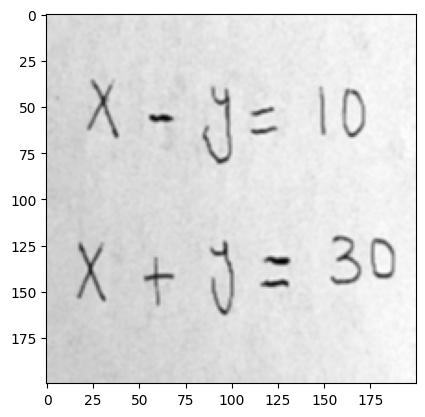

canny image:


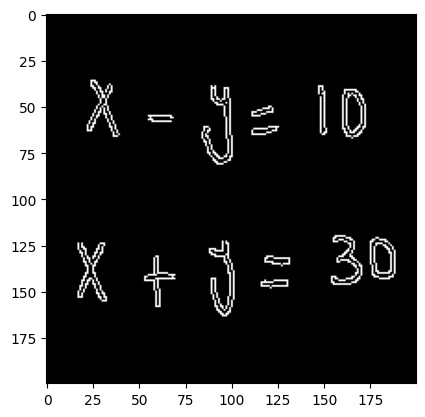

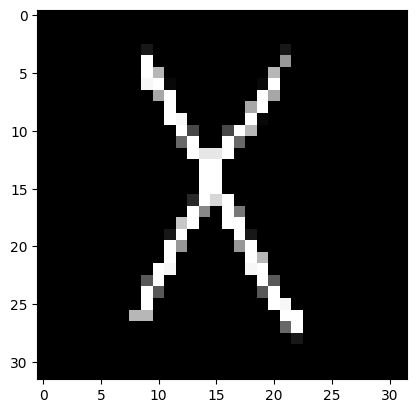

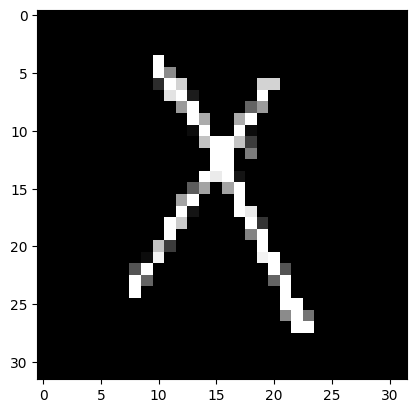

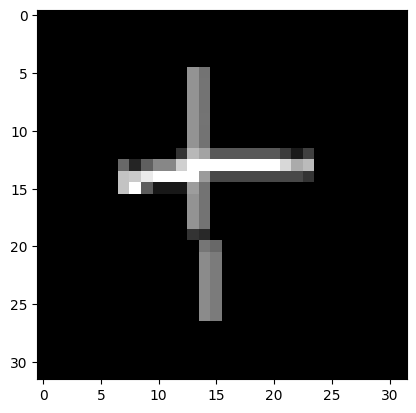

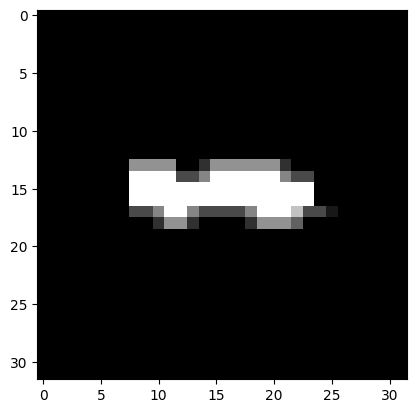

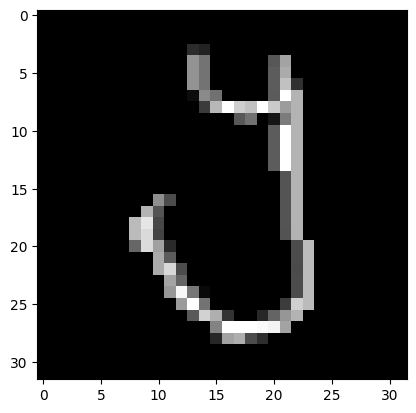

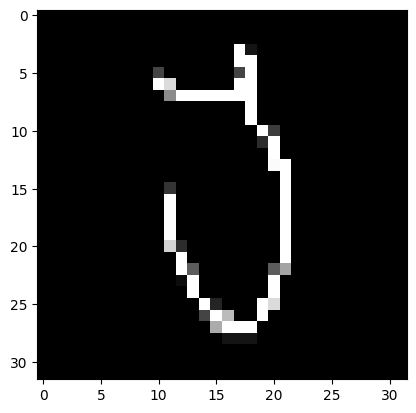

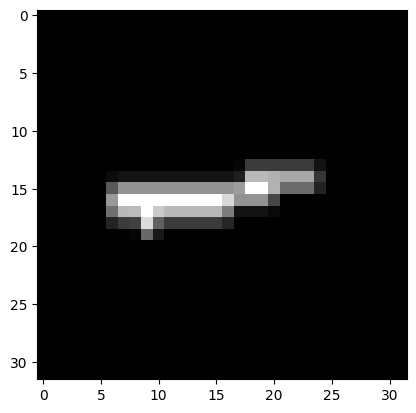

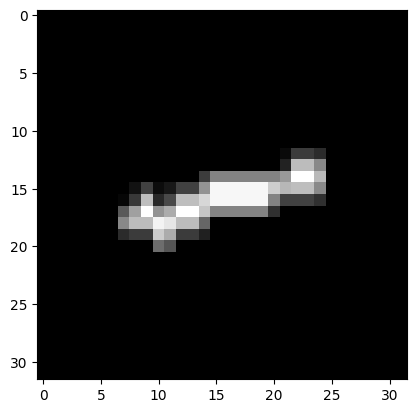

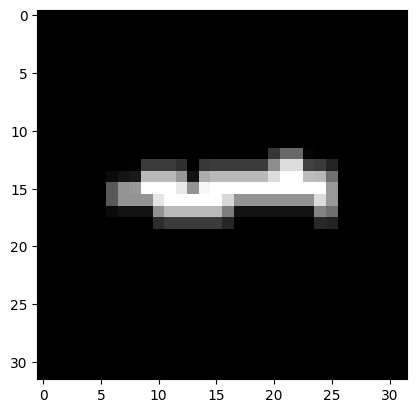

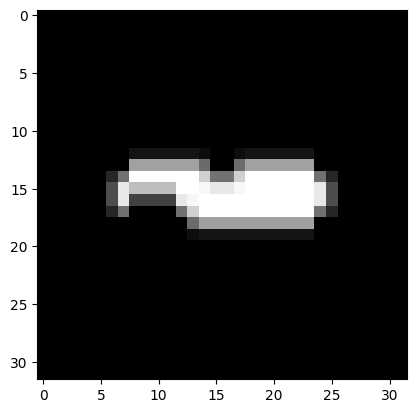

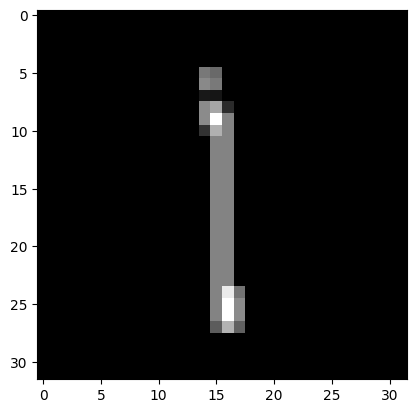

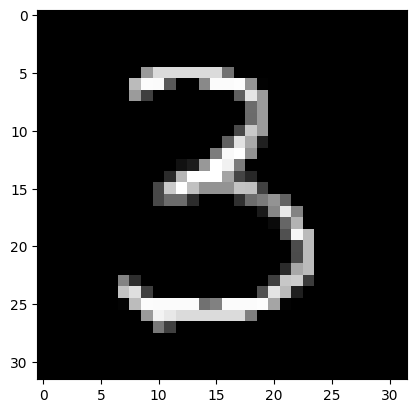

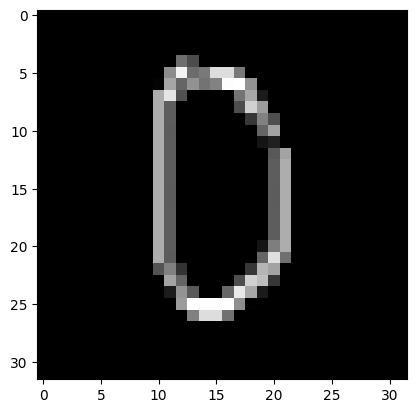

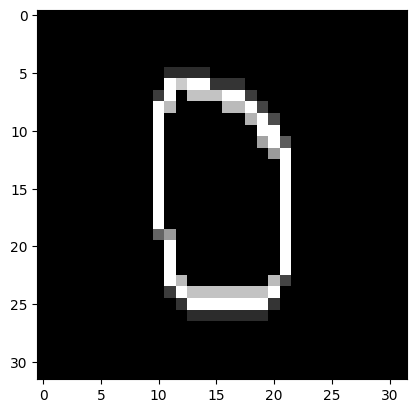

[(17, 124, 16, 32), (22, 36, 18, 31), (53, 131, 17, 28), (55, 55, 14, 4), (84, 39, 17, 43), (88, 123, 14, 41), (111, 61, 15, 5), (111, 50, 12, 6), (116, 144, 15, 5), (118, 131, 14, 6), (147, 39, 5, 27), (154, 120, 17, 27), (160, 41, 13, 27), (175, 121, 14, 23)]


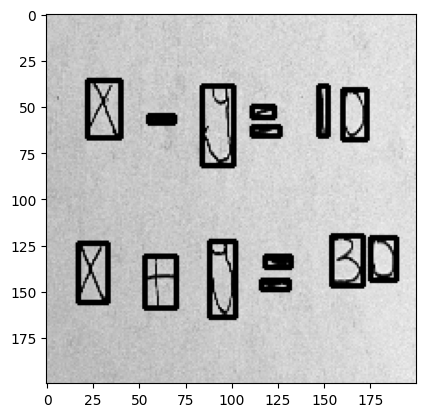

In [88]:
import imutils.contours


img = cv.imread(
    "/home/azimi2kht/projects/camculator/data/IMG_2007.png", cv.IMREAD_GRAYSCALE
)
img = cv.resize(img, (200, 200))
gray = img

img = cv.GaussianBlur(img, (3, 3), 0)
print("blurred image:")
plt.imshow(img, cmap="grey")
plt.show()
img = cv.Canny(img, 20, 150)  # important line
print("canny image:")
plt.imshow(img, cmap="grey")
plt.show()

contours = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)
contours, bb = imutils.contours.sort_contours(contours, method="left-to-right")


chars = []

for x, y, w, h in bb:

    if (w >= 2 and w <= 150) and (h >= 2 and h <= 120):
        roi = gray[y - 5: y + h + 5, x - 5 : x + w + 5]
        (t, thresh) = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
        # or
        # thresh = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)
        (th, tw) = thresh.shape

        if tw > th:
            thresh = imutils.resize(thresh, width=32)
        else:
            thersh = imutils.resize(thresh, height=32)

        th, tw = thresh.shape

        dx = int(max(0, 32 - tw) / 2.0)
        dy = int(max(0, 32 - th) / 2.0)

        padded = cv.copyMakeBorder(
            thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv.BORDER_CONSTANT
        )
        padded = cv.resize(padded, (32, 32))

        chars.append((padded, (x, y, w, h)))

        

boxes = [b[1] for b in chars]
print(boxes)

for x, y, w, h in boxes:
    cv.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.imshow(gray, cmap="grey")
plt.show()
# img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)